### Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from IPython import display

Loading word2vec model, getting its keyword vectors

In [2]:
import gensim.downloader as api
from gensim.models import KeyedVectors
model_name = 'word2vec-google-news-300'
wv: KeyedVectors = api.load(model_name)

Loading dataset into pandas dataframe.

Score column represents how man times annotators considered this pair of two words **more similar** that another word pair of two words. Each annotator was given two words pairs 50 times, where he had to choose a pair of words, where two words are more similar to each other then in another pair. 

In [3]:
import pandas as pd

men_dataset_path = "../../datasets/MEN/MEN_dataset_natural_form_full"

# Read the data into a pandas DataFrame
df = pd.read_csv(
    men_dataset_path, sep=" ", header=None, names=["word1", "word2", "score"]
)

# Display the first 10 rows
df.head(10)

,word1,word2,score
0,sun,sunlight,50.0
1,automobile,car,50.0
2,river,water,49.0
3,stairs,staircase,49.0
4,morning,sunrise,49.0
5,rain,storm,49.0
6,cat,kittens,49.0
7,dance,dancers,49.0
8,camera,photography,49.0
9,cat,feline,48.0


The score is not absolute value, it is relative to another pair. That is we such word pairs like angel-gasoline were chosen by some annotator, because the annotator probably could have choose between, for example, angel-gasoline and bakery-zebra words pairs.

In [4]:
df.tail(10)

,word1,word2,score
2990,posted,tulip,2.0
2991,grave,hat,2.0
2992,apple,cute,2.0
2993,angel,gasoline,1.0
2994,giraffe,harbor,1.0
2995,feathers,truck,1.0
2996,festival,whiskers,1.0
2997,muscle,tulip,1.0
2998,bikini,pizza,1.0
2999,bakery,zebra,0.0


### Normalization of scores and shuffling

Normalizing score column to be a value from 0 to 1

Also, let's shuffle data

In [5]:
df["score"] = df["score"] / 50
df = df.sample(frac=1, random_state=42)
df.head(10)

,word1,word2,score
1801,jean,washing,0.42
1190,blurred,lens,0.60
1817,lunch,morning,0.42
251,daffodils,plant,0.84
2505,animals,sandwich,0.22
1117,bathroom,floor,0.62
1411,birds,wild,0.54
2113,animals,clown,0.32
408,cafe,lunch,0.80
2579,friends,rusty,0.20


### Computing similarity scores using word2vec model

In [23]:
import numpy as np


def similarity(word1: str, word2: str, model: KeyedVectors) -> float | None:
    if word1 not in model or word2 not in model:
        return None
    return -np.linalg.norm(wv[word1] - wv[word2])


print(
    f"cat x dog: cos_sim: {wv.similarity('cat', 'dog')}; euclid_dist: {np.linalg.norm(wv['cat'] - wv['dog'])}"
)
print(
    f"kitty x dog: cos_sim: {wv.similarity('kitty', 'dog')}; euclid_dist: {np.linalg.norm(wv['kitty'] - wv['dog'])}"
)

df["distance"] = df.apply(
    lambda row: similarity(row["word1"], row["word2"], model=wv), axis=1
)

df.head(10)

cat x dog: cos_sim: 0.760945737361908; euclid_dist: 2.081533670425415
kitty x dog: cos_sim: 0.41645821928977966; euclid_dist: 3.197976589202881


,word1,word2,score,similarity,distance
1801,jean,washing,0.42,4.714248,-4.714248
1190,blurred,lens,0.60,4.206619,-4.206619
1817,lunch,morning,0.42,3.031376,-3.031376
251,daffodils,plant,0.84,4.509229,-4.509229
2505,animals,sandwich,0.22,4.204250,-4.204250
1117,bathroom,floor,0.62,3.407804,-3.407804
1411,birds,wild,0.54,3.488908,-3.488908
2113,animals,clown,0.32,3.705152,-3.705152
408,cafe,lunch,0.80,3.423886,-3.423886
2579,friends,rusty,0.20,4.010214,-4.010214


### OOV statistics

In [24]:
OOV_pairs = df[df['distance'].isnull()]
OOV_pairs.head(10)

,word1,word2,score,similarity,distance
314,beach,harbour,0.82,NaN,NaN
2377,theatre,wolf,0.24,NaN,NaN
1321,harbour,town,0.56,NaN,NaN
486,blue,grey,0.78,NaN,NaN
433,bright,colour,0.78,NaN,NaN
1105,dark,grey,0.62,NaN,NaN
2627,held,theatre,0.18,NaN,NaN
170,colour,pink,0.86,NaN,NaN
831,black,colour,0.70,NaN,NaN
1413,cliff,harbour,0.54,NaN,NaN


In [25]:
total_rows_number = df.shape[0]
print(f"Total rows number: {total_rows_number}")

oov_rows_number = OOV_pairs.shape[0]
print(f"Total OOV rows number: {oov_rows_number}")

ratio = oov_rows_number/total_rows_number
print(f"Ratio: {ratio}")

Total rows number: 3000
Total OOV rows number: 54
Ratio: 0.018


### Normalizing similarity scores using linear transformations and linear scaling

Problem is that normalized score's range is [0.0, 1.0], when similarity function range is bound to cosine range [-1.0, 1.0]

Thus, we can see negative similiarity scores:

In [26]:
similarity = df['distance']
min_value = similarity.min()
max_value = similarity.max()
print(f"Max: {max_value}",f"Min: {min_value}")

Max: -1.3384581804275513 Min: -5.398429870605469


### Binary classification using thresholds

In [27]:
# Filter out rows with 'None' similarity
df_filtered = df[df["distance"].notnull()].copy()

In [28]:
actual_class_threshold = 0.5
df_filtered["actual_class"] = df_filtered["score"] > actual_class_threshold

df_filtered.head(10)

,word1,word2,score,similarity,distance,actual_class
1801,jean,washing,0.42,4.714248,-4.714248,False
1190,blurred,lens,0.60,4.206619,-4.206619,True
1817,lunch,morning,0.42,3.031376,-3.031376,False
251,daffodils,plant,0.84,4.509229,-4.509229,True
2505,animals,sandwich,0.22,4.204250,-4.204250,False
1117,bathroom,floor,0.62,3.407804,-3.407804,True
1411,birds,wild,0.54,3.488908,-3.488908,True
2113,animals,clown,0.32,3.705152,-3.705152,False
408,cafe,lunch,0.80,3.423886,-3.423886,True
2579,friends,rusty,0.20,4.010214,-4.010214,False


### Statistics

Now let's use binary classification statistics:

In [29]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve

y_true = np.where(df_filtered["actual_class"], 1, 0)
y_similarity_scores = df_filtered['distance'].to_numpy()
precision, recall, thresholds = precision_recall_curve(y_true, y_similarity_scores)

print(thresholds)

[-5.39842987 -5.3478384  -5.32809639 ... -1.38088095 -1.35131884
 -1.33845818]


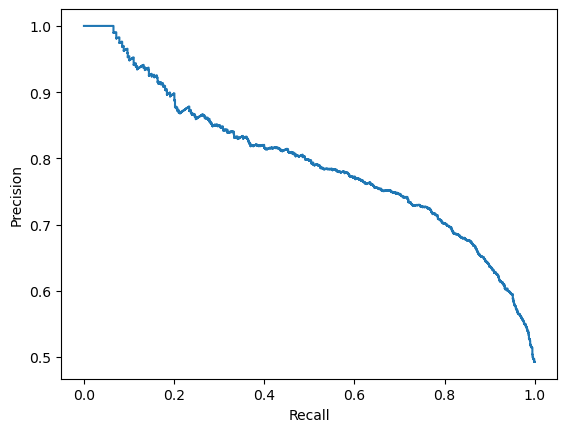

In [30]:
from sklearn.metrics import PrecisionRecallDisplay
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()